In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use(os.path.join(os.getcwd(), 'default.mplstyle'))

from astropy import constants as const
from astropy import units as u

import LWphotorates as pr
from LWphotorates.utils import nu2lambda, lambda2nu, spec_nu2lambda, spec_lambda2nu
# from LWphotorates.utils import convert_energy_cm2ev, convert_energy_ev2cm, convert_energy_cm2k, convert_energy_k2cm
from LWphotorates.utils import generate_blackbody_spectrum, generate_flat_spectrum

In [2]:
data_example_path = os.path.join(os.getcwd(), 'inputdata', 'example_spectra', 'exampleSlug.txt')
data_example = np.loadtxt(data_example_path)

age_stars_SEDs = np.logspace(6, 9, 61)
wl_SEDs = data_example[0] * u.angstrom
spectra_SEDs = data_example[1:] * u.erg / u.s / u.angstrom

freq_SEDs = lambda2nu(wl_SEDs)
energy_SEDs = const.h.to(u.eV / u.Hz) * freq_SEDs

Text(0, 0.5, '$L_\\nu$  [$\\mathrm{erg} \\ \\mathrm{s}^{-1} \\ \\mathrm{\\AA}^{-1}$]')

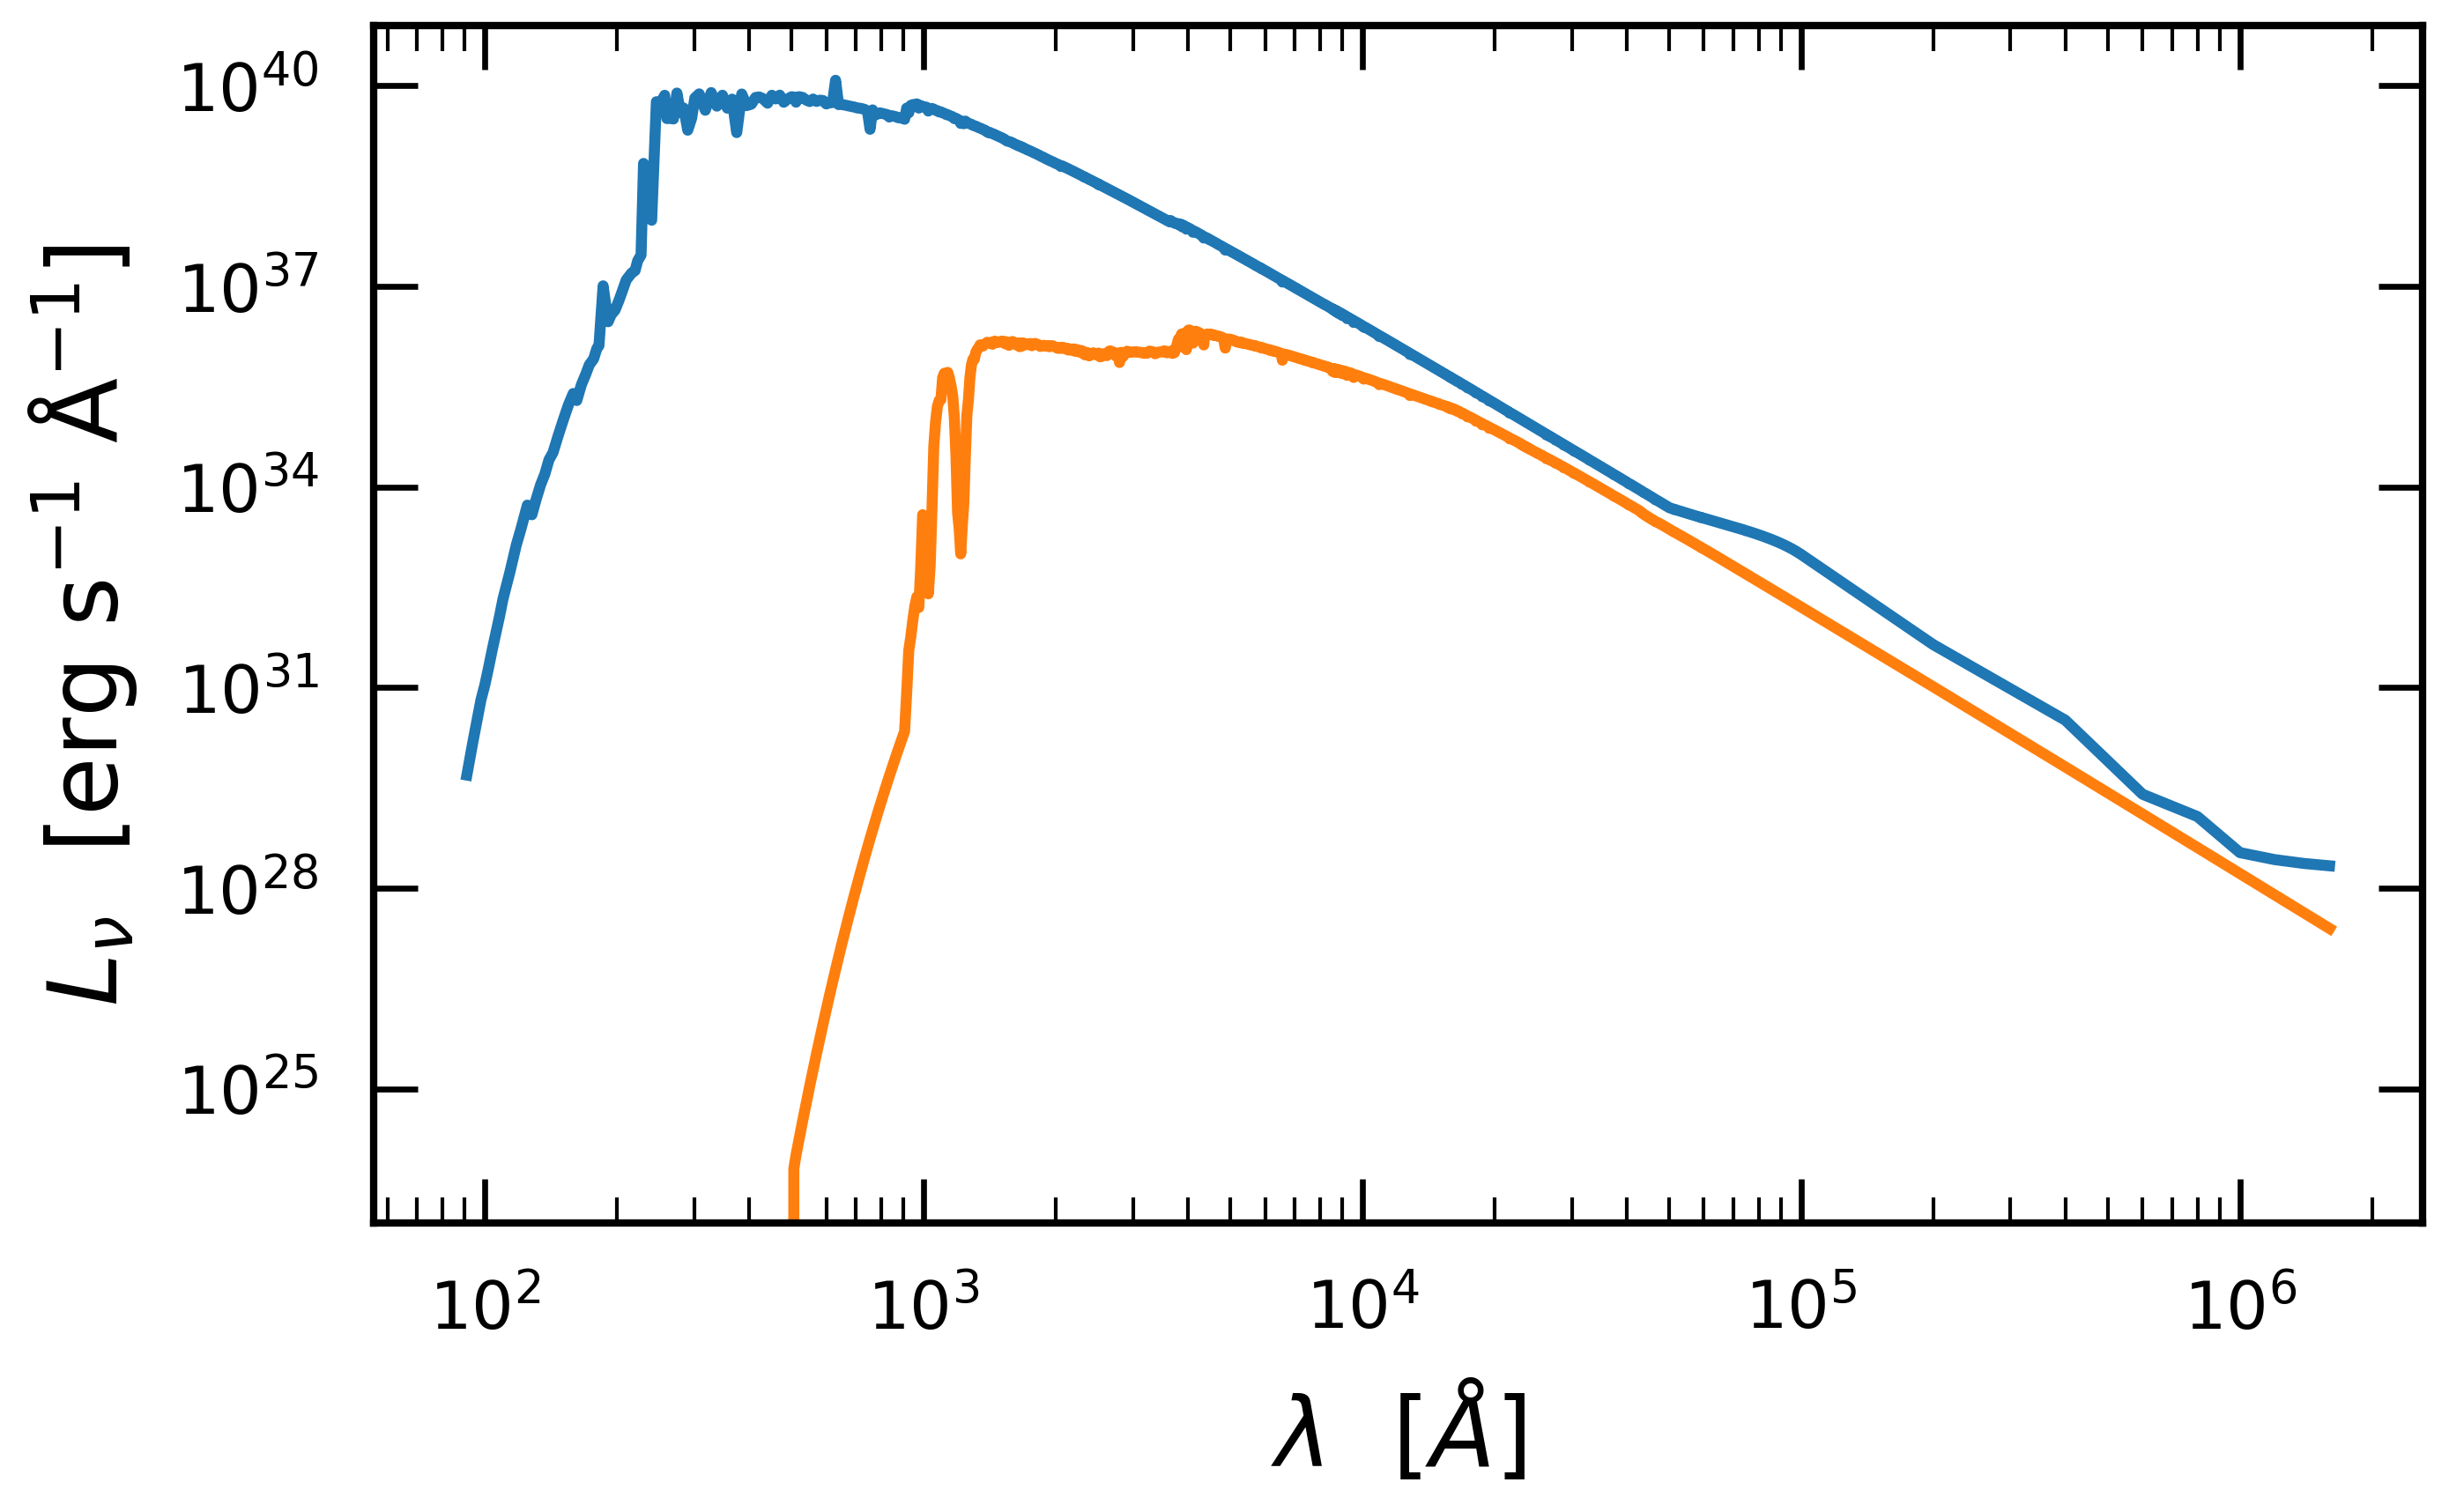

In [8]:
fig, ax = plt.subplots()
ax.plot(wl_SEDs, spectra_SEDs[0], lw=3)
ax.plot(wl_SEDs, spectra_SEDs[-1], lw=3)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\lambda$  [$\AA$]')
ax.set_ylabel(r'$L_\nu$  [$\mathrm{erg} \ \mathrm{s}^{-1} \ \mathrm{\AA}^{-1}$]')

Text(0, 0.5, '$L_\\nu$  [$\\mathrm{erg} \\ \\mathrm{s}^{-1} \\ \\mathrm{Hz}^{-1}$]')

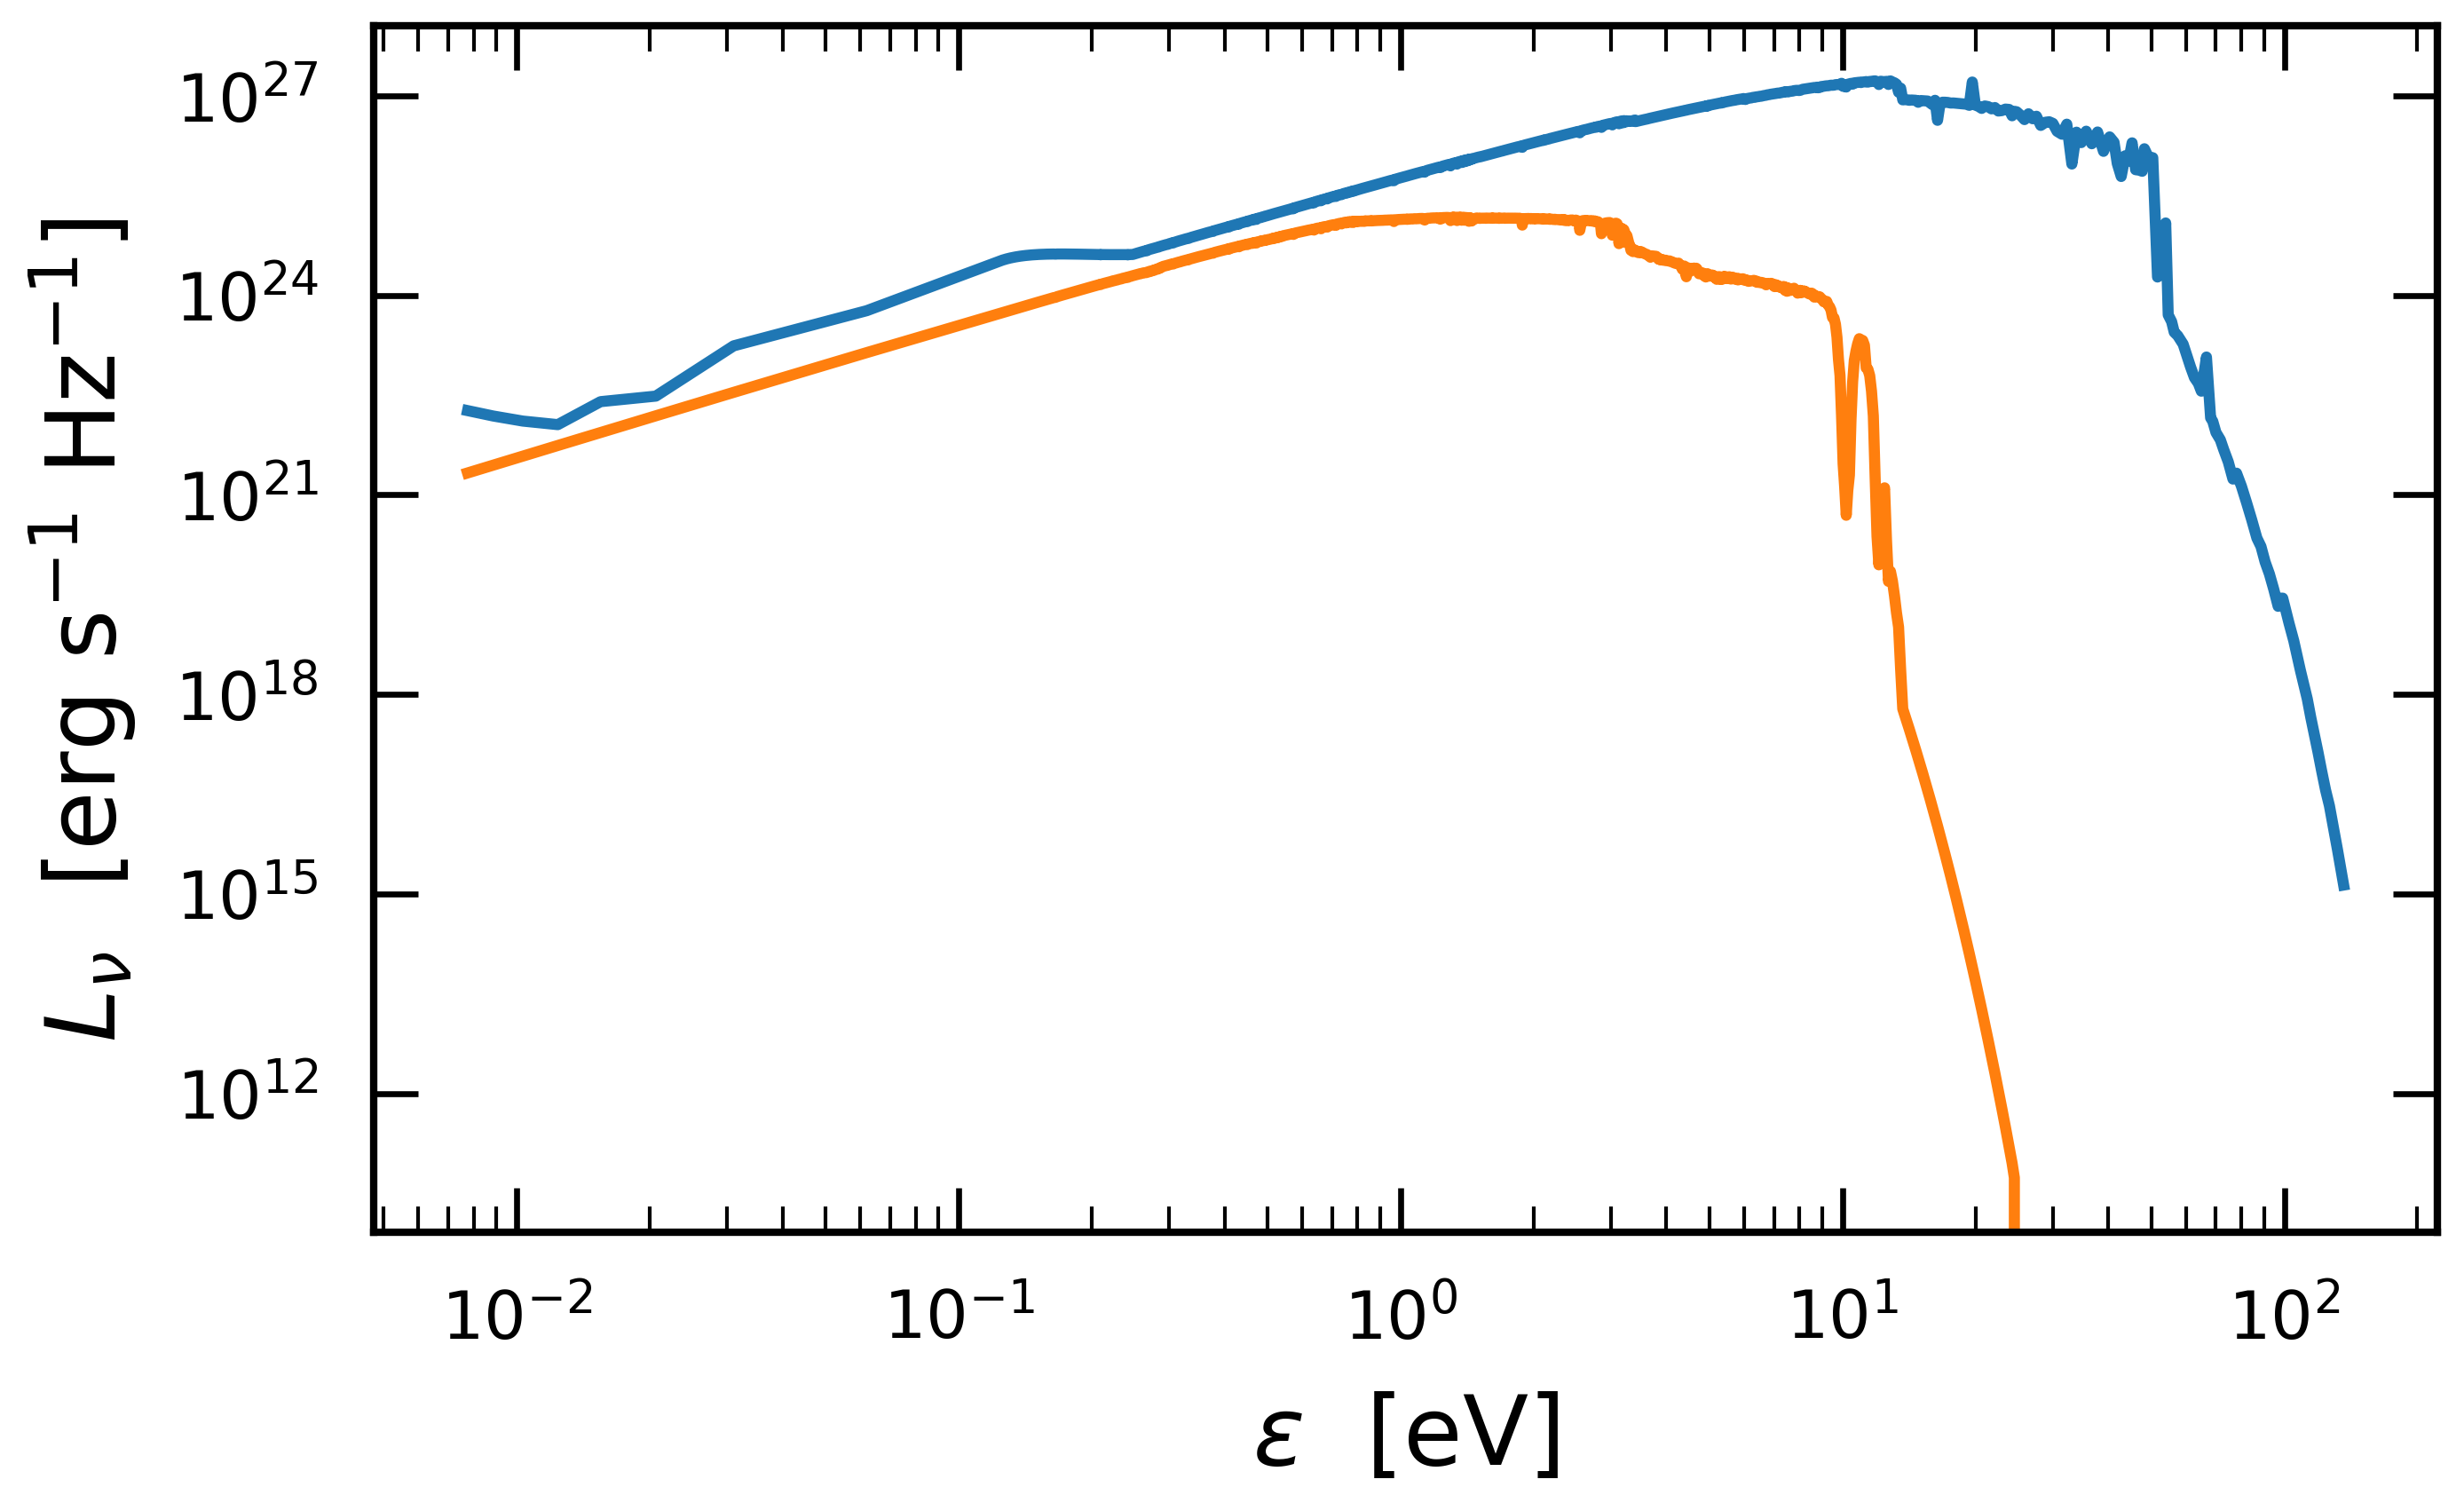

In [10]:
first_spectrum_freq = spec_lambda2nu(wl_SEDs, spectra_SEDs[0])
last_spectrum_freq = spec_lambda2nu(wl_SEDs, spectra_SEDs[-1])

fig, ax = plt.subplots()
ax.plot(energy_SEDs, first_spectrum_freq, lw=3)
ax.plot(energy_SEDs, last_spectrum_freq, lw=3)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\epsilon$  [eV]')
ax.set_ylabel(r'$L_\nu$  [$\mathrm{erg} \ \mathrm{s}^{-1} \ \mathrm{Hz}^{-1}$]')

In [4]:
H2_diss_rate, H2_heating_rate = pr.compute_kH2(
    lambda_array=wl_SEDs,
    spectra_lambda=spectra_SEDs,
    thresh_Xlevel=1e-5,
    thresh_oscxfdiss=1e-6)

HM_detach_rate = pr.compute_kHM(
    lambda_array=wl_SEDs,
    spectra_lambda=spectra_SEDs)

H2p_diss_rate, H2p_heating_rate = pr.compute_kH2p(
    lambda_array=wl_SEDs,
    spectra_lambda=spectra_SEDs)

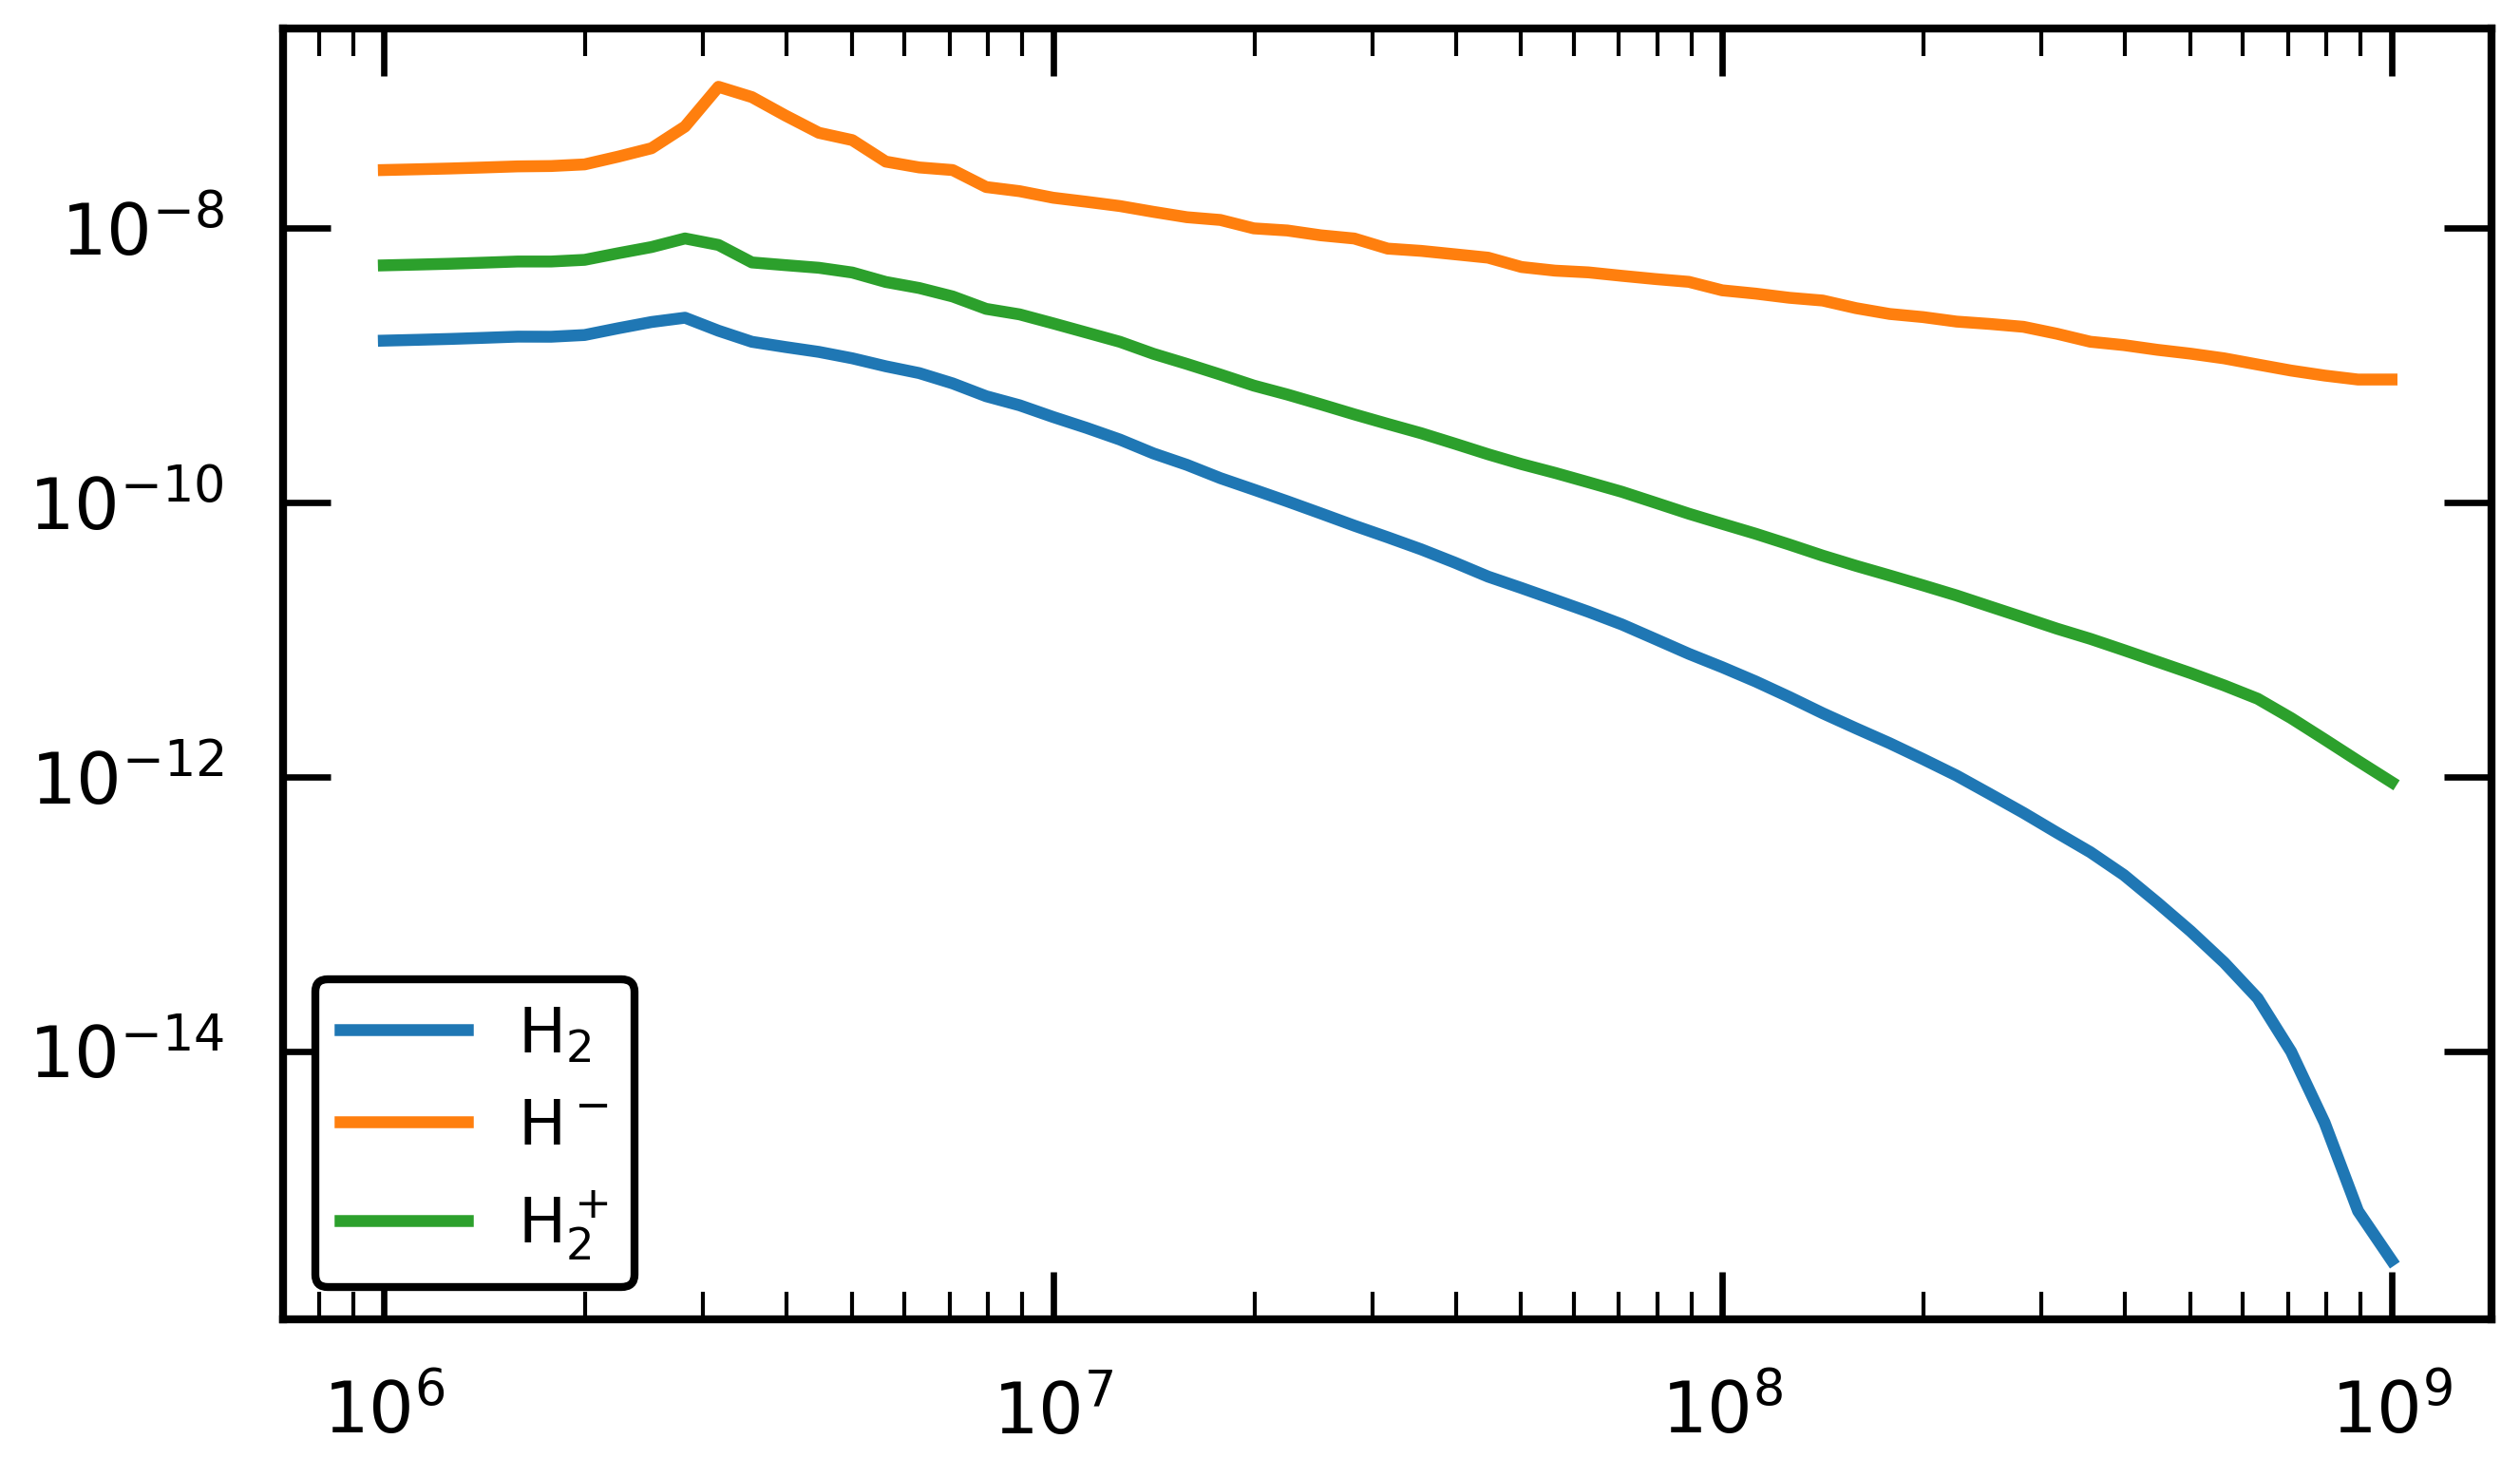

In [5]:
fig, ax = plt.subplots()
ax.plot(age_stars_SEDs, H2_diss_rate, lw=3, label=r'$\mathrm{H}_2$')
ax.plot(age_stars_SEDs, HM_detach_rate, lw=3, label=r'$\mathrm{H}^-$')
ax.plot(age_stars_SEDs, H2p_diss_rate, lw=3, label=r'$\mathrm{H}^+_2$')
ax.set_xscale('log')
ax.set_yscale('log')
legend = ax.legend(ncol=1, loc='best')
legend.get_frame().set_linewidth(2)

## rates for normalised black-body spectra
as in Latif+2015

### define black bodies

In [7]:
custom_energy_array = np.linspace(start=0.1, stop=13.6, num=int(1e4)) * u.eV
custom_frequency_array = custom_energy_array / const.h.to(u.eV / u.Hz)
custom_wavelength_array = nu2lambda(custom_frequency_array)

bb_spectra_array = np.empty(shape=(0, len(custom_wavelength_array)))

radiation_temperature_array = np.logspace(start=3.7, stop=5)
radiation_temperature_array = np.concatenate(([0.], radiation_temperature_array)) * u.K

# this gives a spherical surface of 1 cm^2
distance = np.sqrt(1. / 4. / np.pi) * u.cm

for temperature in radiation_temperature_array:
    if temperature.value == 0:
        spectrum_freq = generate_flat_spectrum(spectrum_length=len(custom_energy_array)) * 1e-21 * 4. * np.pi * u.sr * u.cm**2
    else:
        spectrum_freq = generate_blackbody_spectrum(radiation_temperature=temperature, energy_array=custom_energy_array) * 1e-21 * 4. * np.pi * u.sr * u.cm**2
    spectrum_wl = spec_nu2lambda(custom_frequency_array, spectrum_freq)
    bb_spectra_array = np.vstack((bb_spectra_array, spectrum_wl))

### calculate rates

In [8]:
H2_diss_rate, H2_heating_rate = pr.compute_kH2(
    lambda_array=custom_wavelength_array,
    spectra_lambda=bb_spectra_array,
    distance=distance.to(u.kpc),
    ngas=1e0,
    Tgas=1e2,
    thresh_Xlevel=1e-5,
    thresh_oscxfdiss=1e-6
)

HM_detach_rate = pr.compute_kHM(
    lambda_array=custom_wavelength_array,
    spectra_lambda=bb_spectra_array,
    distance=distance.to(u.kpc)
)

H2p_diss_rate, H2p_heating_rate = pr.compute_kH2p(
    lambda_array=custom_wavelength_array,
    spectra_lambda=bb_spectra_array,
    distance=distance.to(u.kpc),
    ngas=1e0,
    Tgas=1e2
)

/home/inca/miniconda3/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/inca/miniconda3/lib/python3.8/site-packages/frigus/solvers/linear.py:48: LinAlgWarning: Ill-conditioned matrix (rcond=9.93892e-27): result may not be accurate.
  C21 = scipy.linalg.solve(A22, A21)


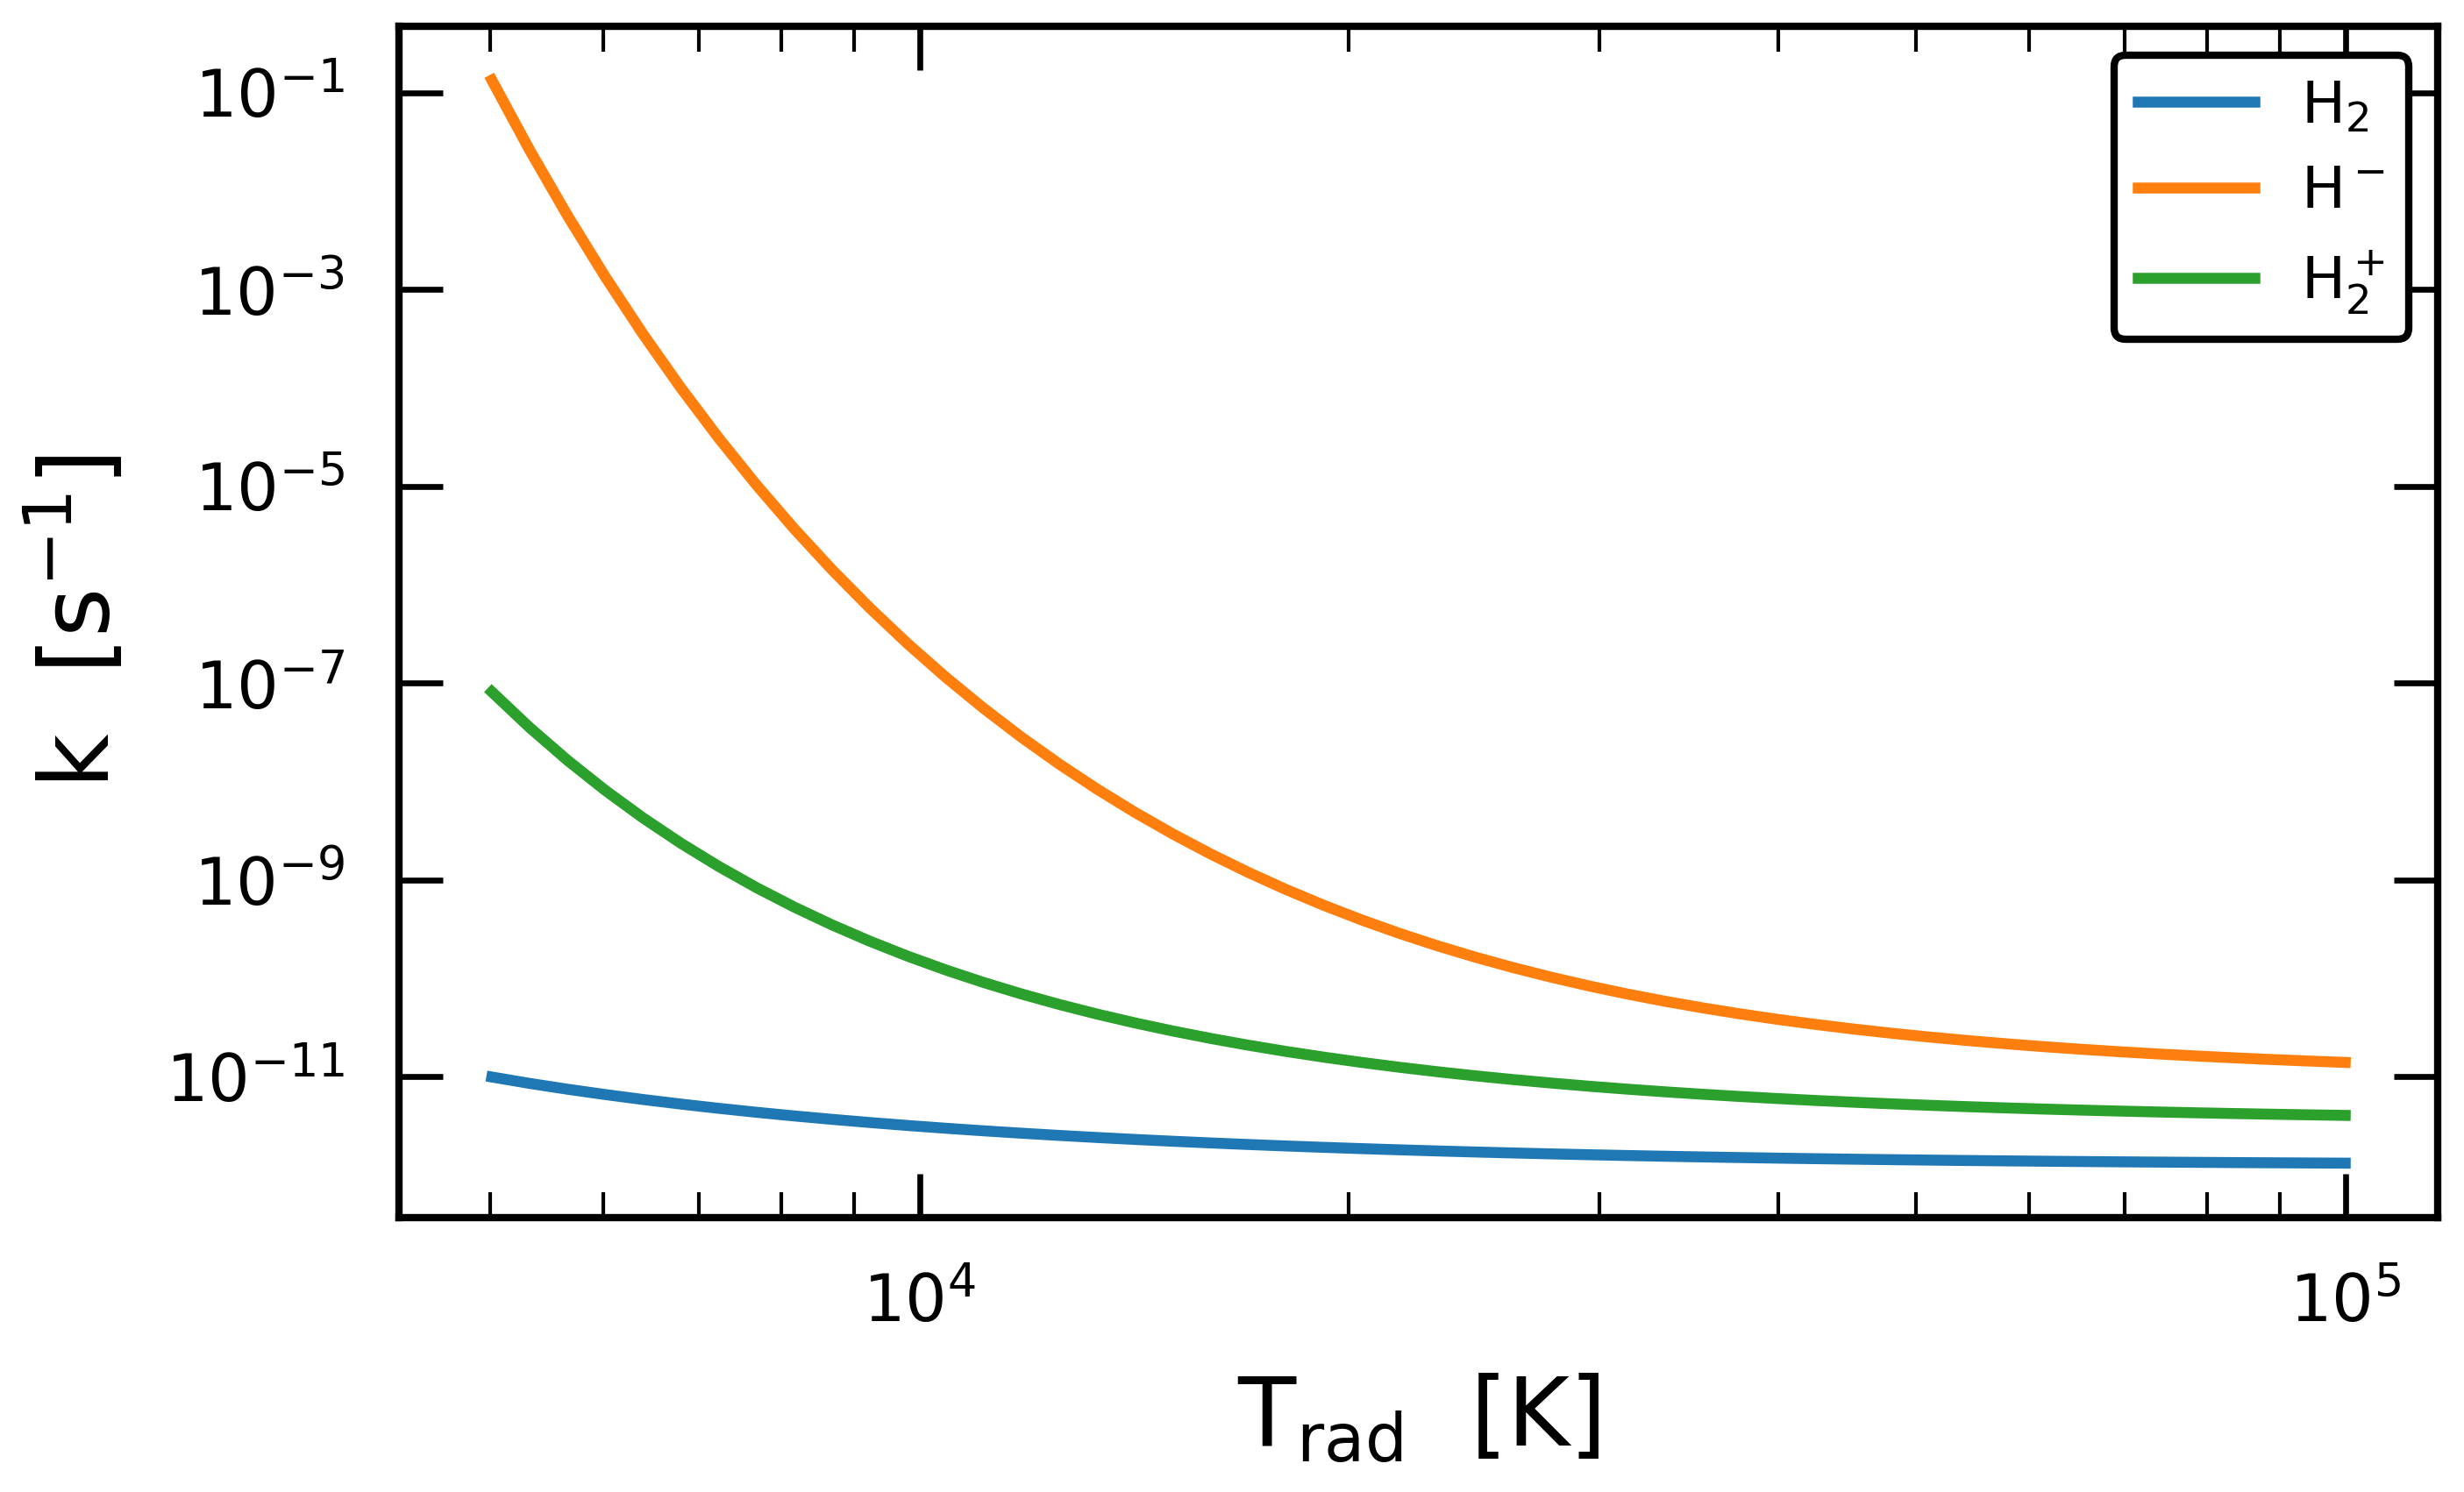

In [9]:
fig, ax = plt.subplots()
ax.plot(radiation_temperature_array[1:], H2_diss_rate[1:], lw=3, label=r'$\mathrm{H}_2$')
ax.plot(radiation_temperature_array[1:], HM_detach_rate[1:], lw=3, label=r'$\mathrm{H}^-$')
ax.plot(radiation_temperature_array[1:], H2p_diss_rate[1:], lw=3, label=r'$\mathrm{H}^+_2$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'T$_\mathrm{rad}$  [K]')
ax.set_ylabel(r'k  [s$^{-1}$]')
legend = ax.legend(ncol=1, loc='best')
legend.get_frame().set_linewidth(2)

### extrapolate fits

In [10]:
H2_fit_coeff0 = 1.1735e-1
H2_fit_coeff1 = 2.4958e-4
H2_fit_coeff2 = 3.4856e-9
H2_fit_coeff3 = 1.1902e1
H2_diss_fit = (H2_fit_coeff0 + H2_fit_coeff1 * radiation_temperature_array[1:].value + H2_fit_coeff2 * radiation_temperature_array[1:].value**2)**(-1.) - H2_fit_coeff3
H2_diss_fit = np.power(10., H2_diss_fit)

In [11]:
HM_fit_coeff0 = 9.08944e-2
HM_fit_coeff1 = 3.27940e-5
HM_fit_coeff2 = 5.98490e-1
HM_fit_coeff3 = 1.09867e1
HM_detach_fit = (HM_fit_coeff0 + HM_fit_coeff1 * radiation_temperature_array[1:].value)**(-1. / HM_fit_coeff2) - HM_fit_coeff3
HM_detach_fit = np.power(10., HM_detach_fit)

In [12]:
H2p_fit_coeff0 = 3.83012e6
H2p_fit_coeff1 = 5.06440e2
H2p_fit_coeff2 = 6.20988e-1
H2p_fit_coeff3 = 3.68778e-12
H2p_diss_fit = (-H2p_fit_coeff0 + H2p_fit_coeff1 * radiation_temperature_array[1:].value)**(-1. / H2p_fit_coeff2) + H2p_fit_coeff3

<ipython-input-12-5d5a52c8ec5e>:5: RuntimeWarning: invalid value encountered in power
  H2p_diss_fit = (-H2p_fit_coeff0 + H2p_fit_coeff1 * radiation_temperature_array[1:].value)**(-1. / H2p_fit_coeff2) + H2p_fit_coeff3


In [13]:
from matplotlib.lines import Line2D
from matplotlib import legend as mlegend

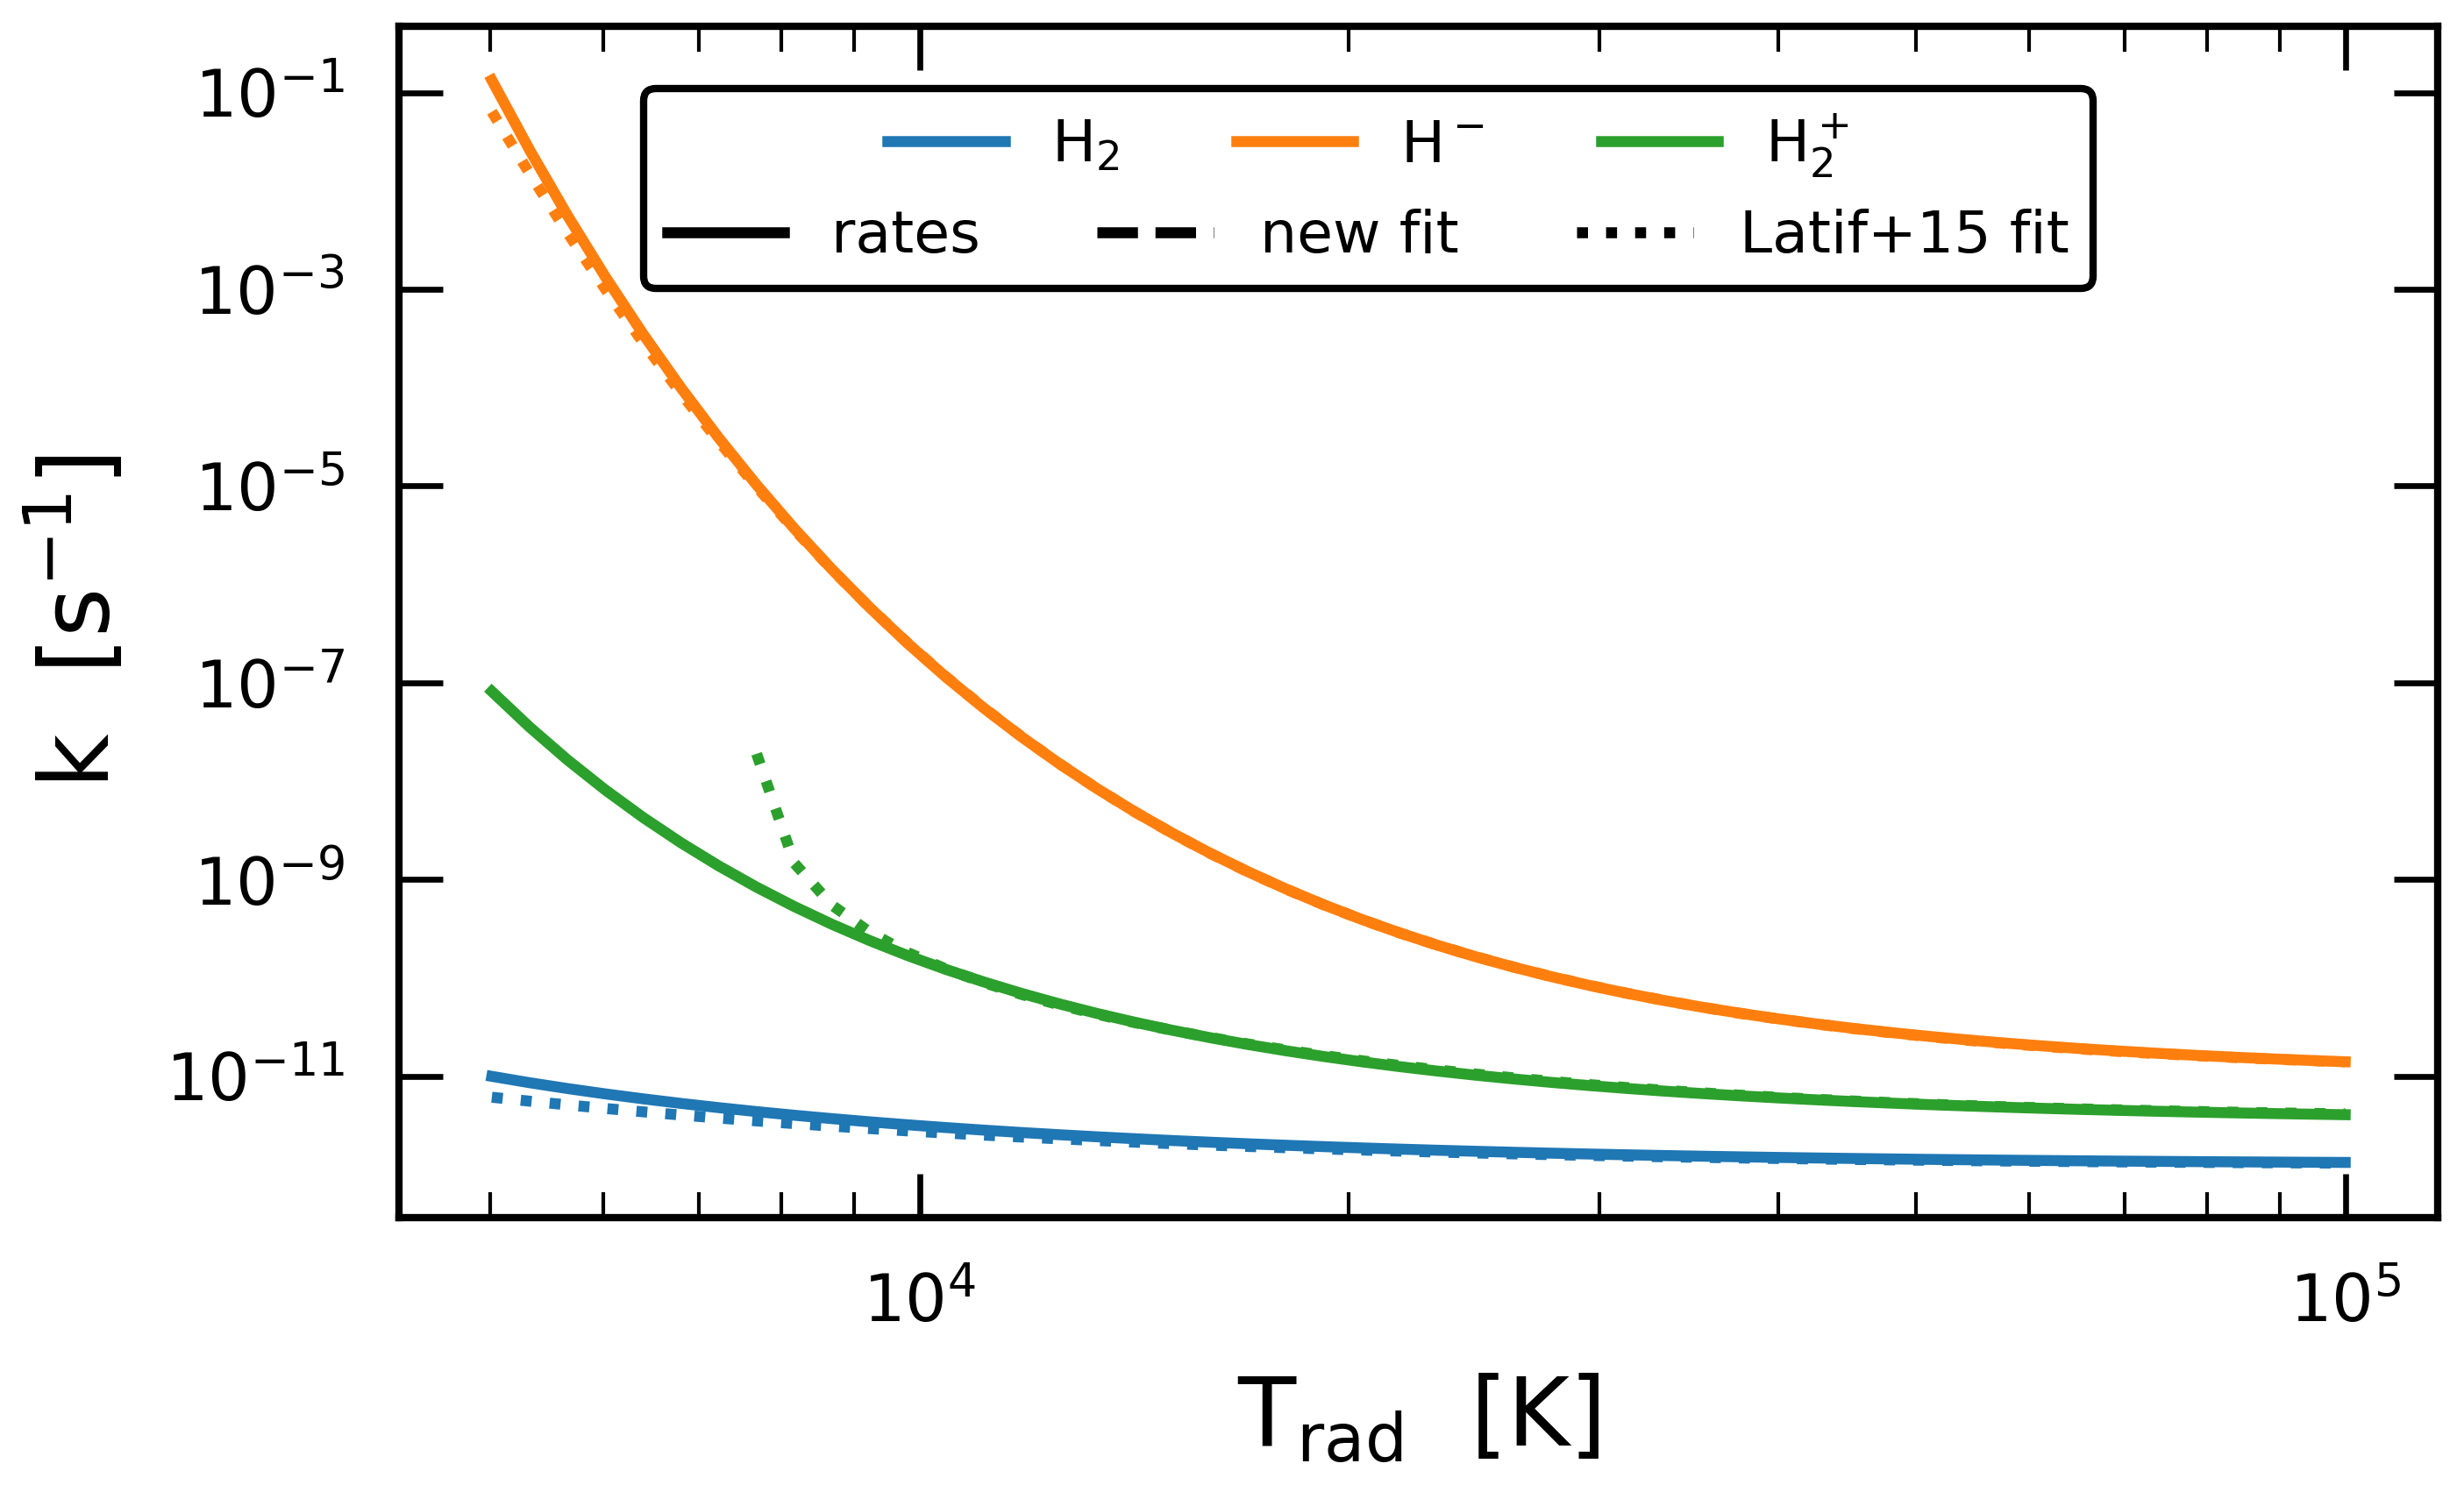

In [14]:
custom_lines1 = [Line2D([0], [0], c='C0', lw=3),
                 Line2D([0], [0], c='C1', lw=3),
                 Line2D([0], [0], c='C2', lw=3)]
custom_lines2 = [Line2D([0], [0], c='k', ls='-', lw=3),
                 Line2D([0], [0], c='k', ls='--',lw=3),
                 Line2D([0], [0], c='k', ls=':', lw=3)]
custom_labels1 = [r'$\mathrm{H}_2$', r'$\mathrm{H}^-$', r'$\mathrm{H}^+_2$']
custom_labels2 = ['rates', 'new fit', 'Latif+15 fit']


fig, ax = plt.subplots()

ax.plot(radiation_temperature_array[1:], H2_diss_rate[1:], lw=3, ls='-', c='C0')
ax.plot(radiation_temperature_array[1:], HM_detach_rate[1:], lw=3, ls='-', c='C1')
ax.plot(radiation_temperature_array[1:], H2p_diss_rate[1:], lw=3, ls='-', c='C2')

ax.plot(radiation_temperature_array[1:], H2_diss_fit, lw=3, ls=':', c='C0')
ax.plot(radiation_temperature_array[1:], HM_detach_fit, lw=3, ls=':', c='C1')
ax.plot(radiation_temperature_array[1:], H2p_diss_fit, lw=3, ls=':', c='C2')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'T$_\mathrm{rad}$  [K]')
ax.set_ylabel(r'k  [s$^{-1}$]')

leg1 = ax.legend(custom_lines1, custom_labels1, ncol=3, loc=(0.12, 0.78))
leg2 = mlegend.Legend(ax, custom_lines2, custom_labels2, ncol=3)
leg1._legend_box._children.append(leg2._legend_box._children[1])
leg1.get_frame().set_linewidth(2)

## flat spectrum

In [15]:
H2_diss_rate_flatspec, H2_heating_rate_flatspec = pr.compute_kH2(
    lambda_array=custom_wavelength_array,
    spectra_lambda=bb_spectra_array[0],
    distance=distance.to(u.kpc),
    ngas=1e0,
    Tgas=1e2,
    thresh_Xlevel=1e-5,
    thresh_oscxfdiss=1e-6
)

HM_detach_rate_flatspec = pr.compute_kHM(
    lambda_array=custom_wavelength_array,
    spectra_lambda=bb_spectra_array[0],
    distance=distance.to(u.kpc)
)

H2p_diss_rate_flatspec, H2p_heating_rate_flatspec = pr.compute_kH2p(
    lambda_array=custom_wavelength_array,
    spectra_lambda=bb_spectra_array[0],
    distance=distance.to(u.kpc),
    ngas=1e0,
    Tgas=1e2
)

/home/inca/miniconda3/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/inca/miniconda3/lib/python3.8/site-packages/frigus/solvers/linear.py:48: LinAlgWarning: Ill-conditioned matrix (rcond=9.93892e-27): result may not be accurate.
  C21 = scipy.linalg.solve(A22, A21)


In [16]:
print(H2_diss_rate_flatspec[0])
print(HM_detach_rate_flatspec[0])
print(H2p_diss_rate_flatspec[0])

1.4106328576806065e-12 1 / s
1.1024082847597092e-10 1 / s
5.306059154376745e-12 1 / s


## random tests

H2p: GS vs LTE, Zammit vs Babb

In [17]:
gas_temperature_GS = 1e2 * u.K
gas_density_GS = 1e0 / u.cm**3

In [18]:
gas_temperature_LTE = 5e3 * u.K

pr.H2p.calc_ncrit(Tgas=gas_temperature_LTE)

<Quantity 696.53388515 1 / cm3>

In [19]:
gas_density_LTE = 1e4 / u.cm**3

In [20]:
H2p_diss_rate_GS_B, H2p_heating_rate_GS_B = pr.compute_kH2p(
    lambda_array=custom_wavelength_array,
    spectra_lambda=bb_spectra_array[0],
    distance=distance.to(u.kpc),
    ngas=gas_density_GS,
    Tgas=gas_temperature_GS,
    Zammit=False
)

H2p_diss_rate_GS_Z, H2p_heating_rate_GS_Z = pr.compute_kH2p(
    lambda_array=custom_wavelength_array,
    spectra_lambda=bb_spectra_array[0],
    distance=distance.to(u.kpc),
    ngas=gas_density_GS,
    Tgas=gas_temperature_GS,
    Zammit=True
)

H2p_diss_rate_LTE_B, H2p_heating_rate_LTE_B = pr.compute_kH2p(
    lambda_array=custom_wavelength_array,
    spectra_lambda=bb_spectra_array[0],
    distance=distance.to(u.kpc),
    ngas=gas_density_LTE,
    Tgas=gas_temperature_LTE,
    Zammit=False
)

H2p_diss_rate_LTE_Z, H2p_heating_rate_LTE_Z = pr.compute_kH2p(
    lambda_array=custom_wavelength_array,
    spectra_lambda=bb_spectra_array[0],
    distance=distance.to(u.kpc),
    ngas=gas_density_LTE,
    Tgas=gas_temperature_LTE,
    Zammit=True
)

In [21]:
print('{0: >12}: \t {1}'.format('GS - Babb', H2p_diss_rate_GS_B[0]))
print('{0: >12}: \t {1}'.format('LTE - Babb', H2p_diss_rate_LTE_B[0]))
print('{0: >12}: \t {1}'.format('GS - Zammit', H2p_diss_rate_GS_Z[0]))
print('{0: >12}: \t {1}'.format('LTE - Zammit', H2p_diss_rate_LTE_Z[0]))

   GS - Babb: 	 5.30949937230793e-12 1 / s
  LTE - Babb: 	 5.133369148039544e-12 1 / s
 GS - Zammit: 	 5.306059154376745e-12 1 / s
LTE - Zammit: 	 6.546341382028461e-12 1 / s
